# **Importing Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from xgboost.sklearn import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers


# **A. Data Extraction and Cleaning**

In [2]:
data=pd.read_csv('justice.csv')
data.head()

Unnamed: 0     ID                     name  \
0           0  50606              Roe v. Wade   
1           1  50613      Stanley v. Illinois   
2           2  50623  Giglio v. United States   
3           3  50632             Reed v. Reed   
4           4  50643     Miller v. California   

                                      href   docket  term  \
0    https://api.oyez.org/cases/1971/70-18    70-18  1971   
1  https://api.oyez.org/cases/1971/70-5014  70-5014  1971   
2    https://api.oyez.org/cases/1971/70-29    70-29  1971   
3     https://api.oyez.org/cases/1971/70-4     70-4  1971   
4    https://api.oyez.org/cases/1971/70-73    70-73  1971   

           first_party   second_party  \
0             Jane Roe     Henry Wade   
1  Peter Stanley, Sr.        Illinois   
2         John Giglio   United States   
3           Sally Reed     Cecil Reed   
4        Marvin Miller     California   

                                               facts  facts_len  \
0  <p>In 1970, Jane Roe (a fictional name used in...        501   
1  <p>Joan Stanley had three children with Peter ...        757   
2  <p>John Giglio was convicted of passing forged...        495   
3  <p>The Idaho Probate Code specified that "male...        378   
4  <p>Miller, after conducting a mass mailing cam...        305   

   majority_vote  minority_vote first_party_winner     decision_type  \
0              7              2               True  majority opinion   
1              5              2               True  majority opinion   
2              7              0               True  majority opinion   
3              7              0               True  majority opinion   
4              5              4               True  majority opinion   

         disposition       issue_area  
0           reversed              NaN  
1  reversed/remanded     Civil Rights  
2  reversed/remanded      Due Process  
3  reversed/remanded     Civil Rights  
4   vacated/remanded  First Amendment

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3303 entries, 0 to 3302
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          3303 non-null   int64 
 1   ID                  3303 non-null   int64 
 2   name                3303 non-null   object
 3   href                3303 non-null   object
 4   docket              3292 non-null   object
 5   term                3303 non-null   object
 6   first_party         3302 non-null   object
 7   second_party        3302 non-null   object
 8   facts               3303 non-null   object
 9   facts_len           3303 non-null   int64 
 10  majority_vote       3303 non-null   int64 
 11  minority_vote       3303 non-null   int64 
 12  first_party_winner  3288 non-null   object
 13  decision_type       3296 non-null   object
 14  disposition         3231 non-null   object
 15  issue_area          3161 non-null   object
dtypes: int64(5), object(11)


In [4]:
data.describe() #descriptive statistics

Unnamed: 0            ID    facts_len  majority_vote  minority_vote
count  3303.000000   3303.000000  3303.000000    3303.000000    3303.000000
mean   1651.000000  56336.505298  1112.496821       7.009688       1.727823
std     953.638296   3600.259018   531.514960       1.726244       1.604460
min       0.000000  50606.000000    26.000000       0.000000       0.000000
25%     825.500000  54339.500000   757.000000       5.000000       0.000000
50%    1651.000000  55260.000000  1049.000000       7.000000       2.000000
75%    2476.500000  59437.500000  1381.000000       9.000000       3.000000
max    3302.000000  63335.000000  6201.000000       9.000000       4.000000

In [5]:
null_values = data.isnull().sum() #identifying missing values

In [6]:
null_values.index[0]

'Unnamed: 0'

In [7]:
print('There are {} missing values for {} and {} missing values for {}.'.format(null_values[0],null_values.index[0],null_values[1],null_values.index[1]))

There are 0 missing values for Unnamed: 0 and 0 missing values for ID.


C:\Users\Anita Singh\AppData\Local\Temp\ipykernel_24740\1794822848.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('There are {} missing values for {} and {} missing values for {}.'.format(null_values[0],null_values.index[0],null_values[1],null_values.index[1]))


In [8]:
data['facts'] = data['facts'].apply(lambda st: st[3:len(st)-4]) 

In [9]:
num_duplicates = data.duplicated().sum() #identify duplicates
print('There are {} duplicate facts present in the dataset'.format(num_duplicates))

There are 0 duplicate facts present in the dataset


In [10]:
#view duplicate facts
facts = data['facts']
duplicated_facts = data[facts.isin(facts[facts.duplicated()])].sort_values("facts")
duplicated_facts.head()

Unnamed: 0     ID                   name  \
1242        1242  54829  Arizona v. California   
1260        1260  54843  Arizona v. California   

                                        href  docket  term first_party  \
1242  https://api.oyez.org/cases/2000/8_orig  8-orig  2000     Arizona   
1260  https://api.oyez.org/cases/1999/8_orig  8-orig  1999     Arizona   

     second_party                                              facts  \
1242   California  In 1952, Arizona invoked the U.S. Supreme Cour...   
1260   California  In 1952, Arizona invoked the U.S. Supreme Cour...   

      facts_len  majority_vote  minority_vote first_party_winner  \
1242       1614              6              3               True   
1260       1614              6              3               True   

         decision_type        disposition issue_area  
1242  majority opinion  reversed/remanded        NaN  
1260  majority opinion  reversed/remanded        NaN

In [11]:
#drop duplicate facts
data.drop_duplicates(inplace = True)

In [12]:
print('The dataset contains {} rows and {} columns after removing duplicates'.format(data.shape[0],data.shape[1]))

The dataset contains 3303 rows and 16 columns after removing duplicates


In [13]:
stop = stopwords.words('english')
wl = WordNetLemmatizer()

In [14]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }

In [15]:
#function to clean data
def clean_text(text,lemmatize = True):
    soup = BeautifulSoup(text, "html.parser") #remove html tags
    text = soup.get_text()
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #expanding chatwords and contracts clearing contractions
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text = re.sub(r'http\S+', '', text) #remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) #remove punctuation
    #tokens = re.split('\W+', text) #create tokens
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()]) 
    return text

In [16]:
data['facts']=data['facts'].apply(clean_text,lemmatize = True)

In [17]:
#converting target variable to numeric labels
data['verdict'] = [ 1 if verdict == True else 0 for verdict in data.first_party_winner]

In [18]:
#after converting labels
data.head(5)

Unnamed: 0     ID                     name  \
0           0  50606              Roe v. Wade   
1           1  50613      Stanley v. Illinois   
2           2  50623  Giglio v. United States   
3           3  50632             Reed v. Reed   
4           4  50643     Miller v. California   

                                      href   docket  term  \
0    https://api.oyez.org/cases/1971/70-18    70-18  1971   
1  https://api.oyez.org/cases/1971/70-5014  70-5014  1971   
2    https://api.oyez.org/cases/1971/70-29    70-29  1971   
3     https://api.oyez.org/cases/1971/70-4     70-4  1971   
4    https://api.oyez.org/cases/1971/70-73    70-73  1971   

           first_party   second_party  \
0             Jane Roe     Henry Wade   
1  Peter Stanley, Sr.        Illinois   
2         John Giglio   United States   
3           Sally Reed     Cecil Reed   
4        Marvin Miller     California   

                                               facts  facts_len  \
0  jane roe fictional name used court document pr...        501   
1  joan stanley three child peter stanley stanley...        757   
2  john giglio convicted passing forged money ord...        495   
3  idaho probate code specified male must preferr...        378   
4  miller conducting mass mailing campaign advert...        305   

   majority_vote  minority_vote first_party_winner     decision_type  \
0              7              2               True  majority opinion   
1              5              2               True  majority opinion   
2              7              0               True  majority opinion   
3              7              0               True  majority opinion   
4              5              4               True  majority opinion   

         disposition       issue_area  verdict  
0           reversed              NaN        1  
1  reversed/remanded     Civil Rights        1  
2  reversed/remanded      Due Process        1  
3  reversed/remanded     Civil Rights        1  
4   vacated/remanded  First Amendment        1

In [19]:
data.to_csv("processed_justice.csv");

# **B. Exploratory data analysis** 

C:\Users\Anita Singh\AppData\Local\Temp\ipykernel_24740\501745661.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data.verdict,palette = ['green','red'],order = [1,0])


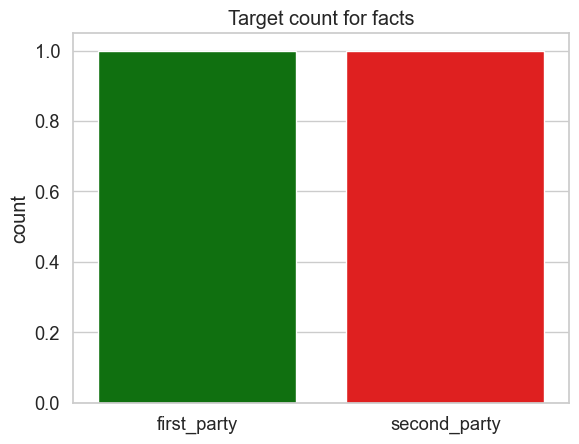

In [20]:
### Count Plot
sns.set(style = "whitegrid" , font_scale = 1.2)
sns.countplot(data.verdict,palette = ['green','red'],order = [1,0])
plt.xticks(ticks = np.arange(2),labels = ['first_party','second_party'])
plt.title('Target count for facts')
plt.show()

In [21]:
print('first_party facts are', (round(data['verdict'].value_counts()[0])),'i.e.', round(data['verdict'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('second_party facts are', (round(data['verdict'].value_counts()[1])),'i.e.',round(data['verdict'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

first_party facts are 1163 i.e. 35.21 % of the dataset
second_party facts are 2140 i.e. 64.79 % of the dataset


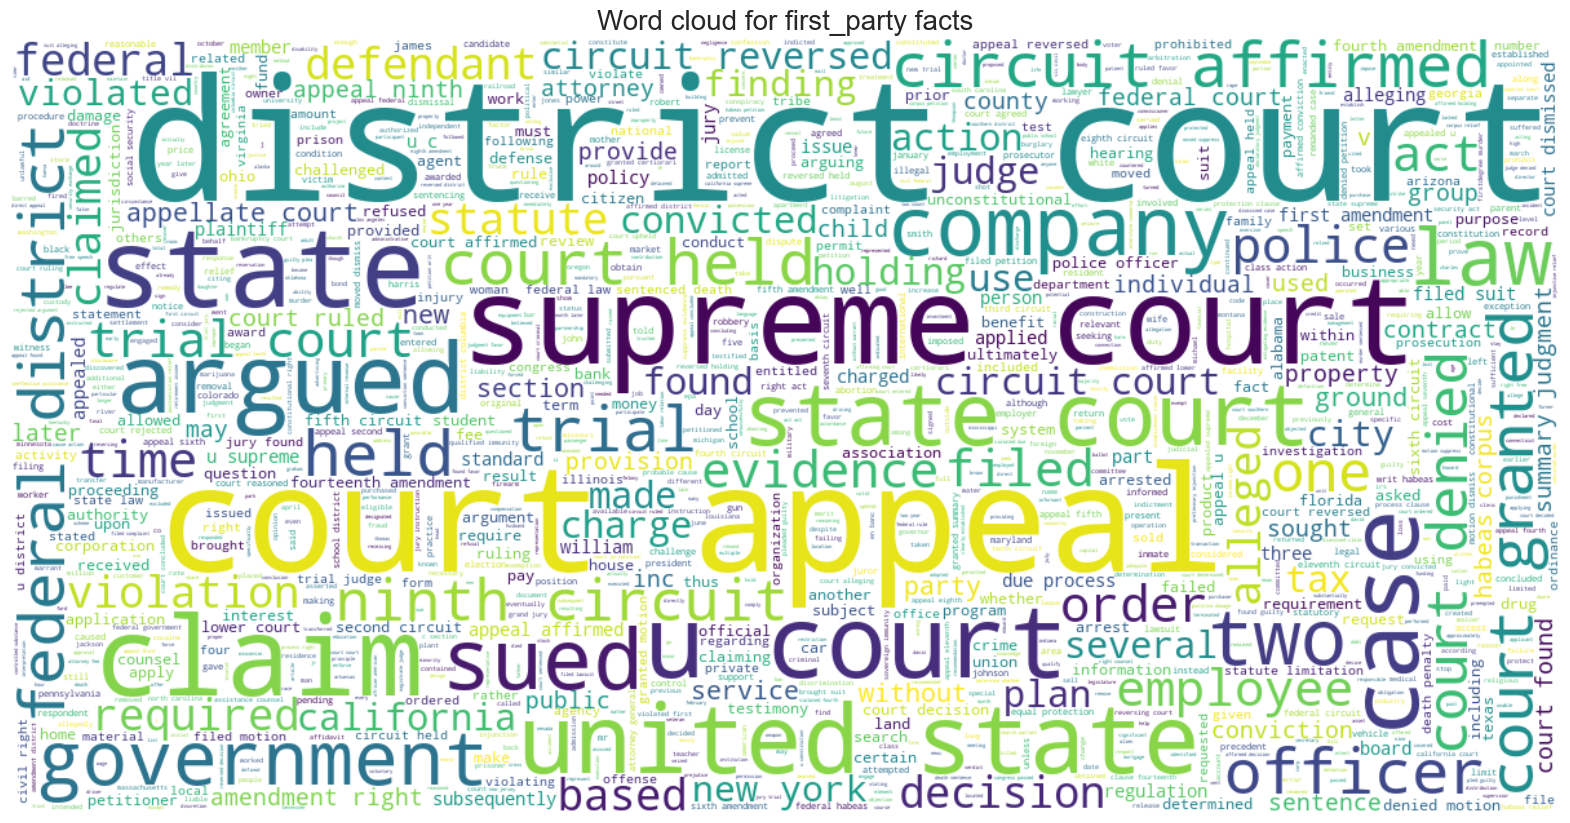

In [22]:
#word cloud for first_party facts
first_party_data = data[data.verdict == 1]['facts']
first_party_data_string = ' '.join(first_party_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(first_party_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for first_party facts',fontsize = 20)
plt.show()

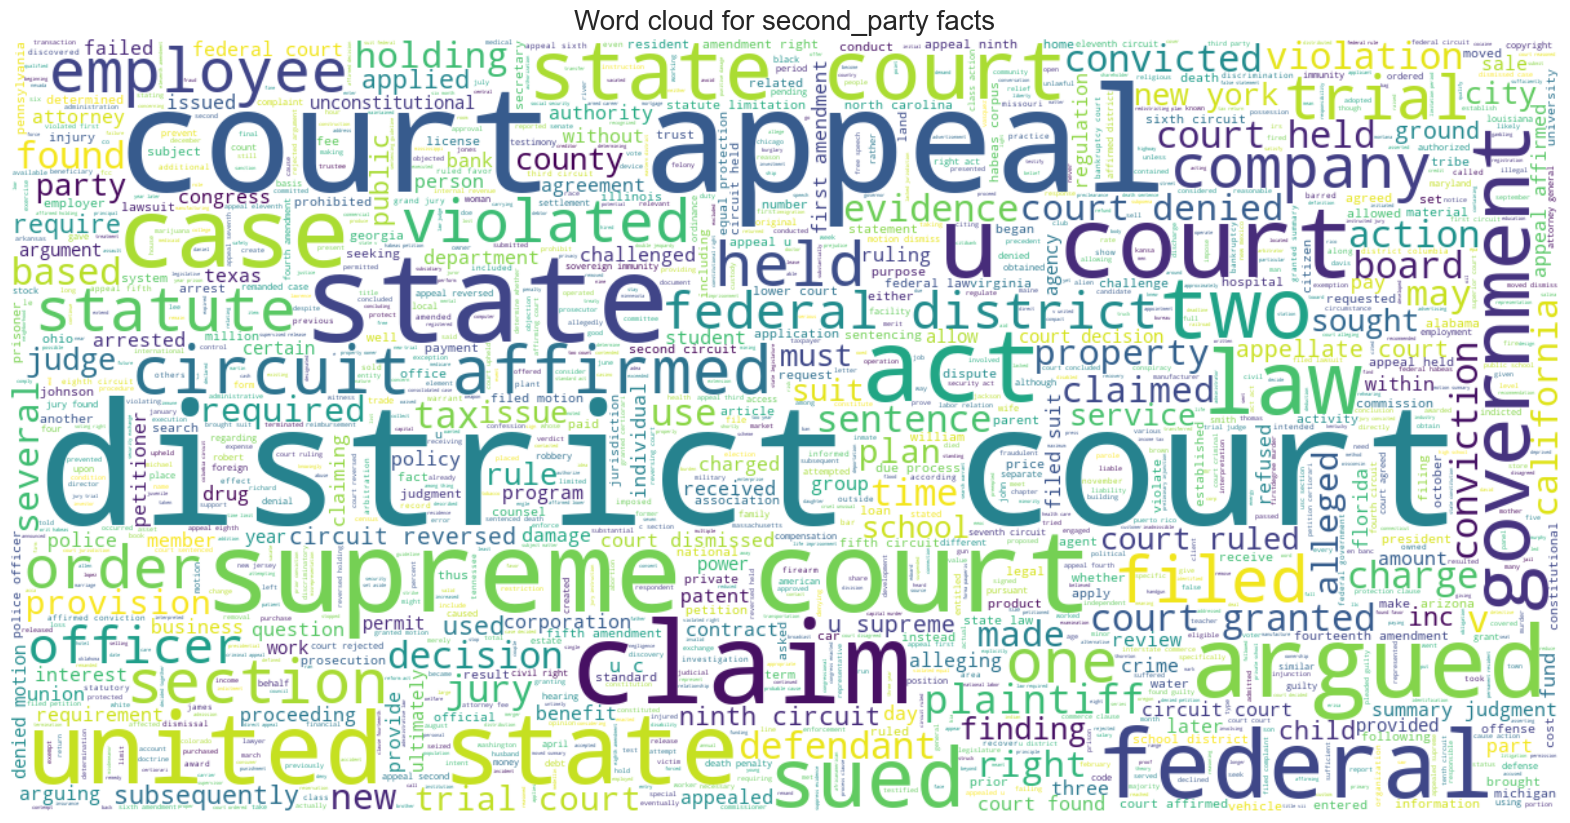

In [23]:
#word cloud for second_party facts
second_party_data = data[data.verdict == 0]['facts']
second_party_data_string = ' '.join(second_party_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(second_party_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for second_party facts',fontsize = 20)
plt.show()

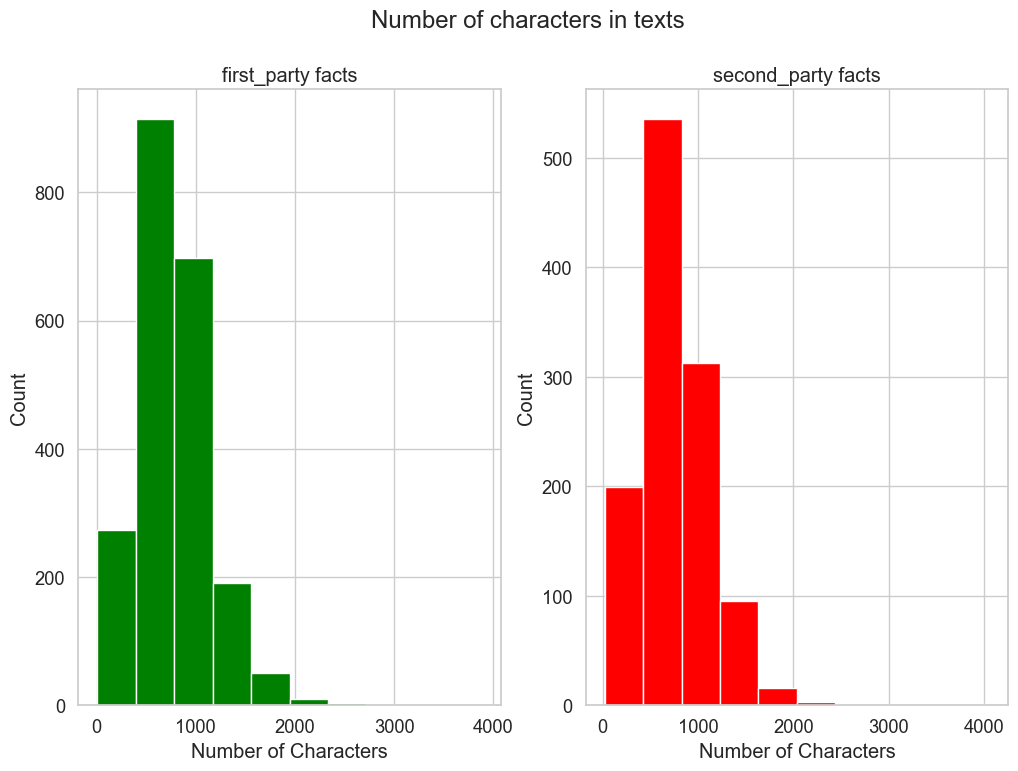

In [24]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=first_party_data.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('first_party facts')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Count')
text_len=second_party_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('second_party facts')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Count')
fig.suptitle('Number of characters in texts')
plt.show()

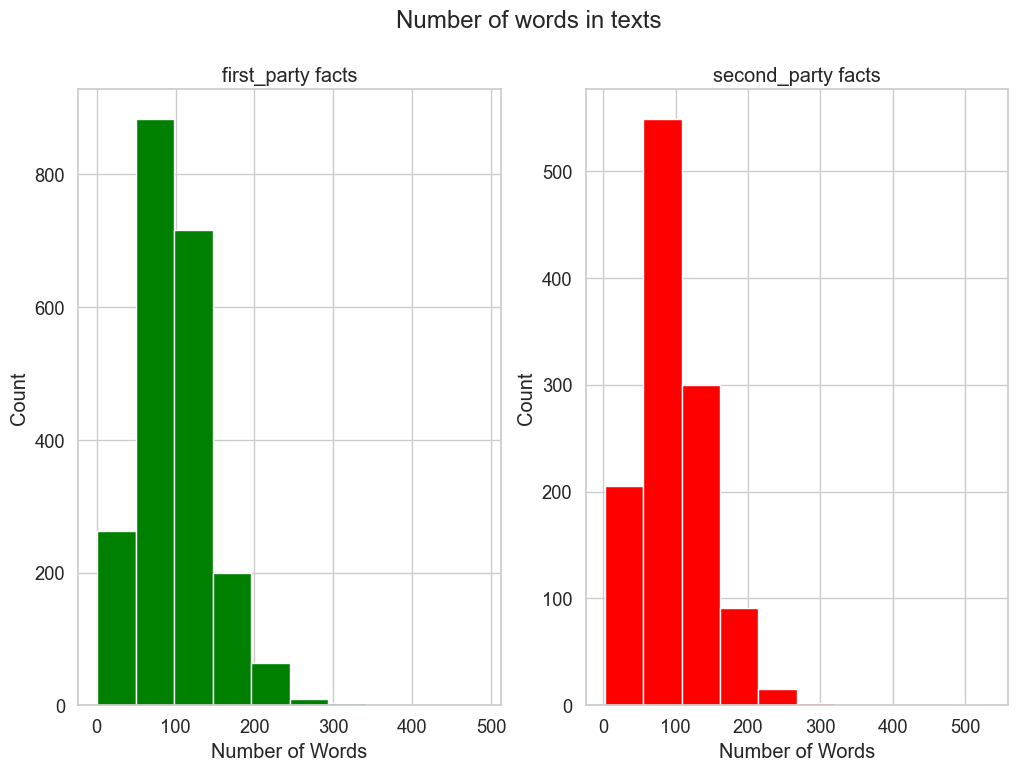

In [25]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=first_party_data.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('first_party facts')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=second_party_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('second_party facts')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in texts')
plt.show()

C:\Users\Anita Singh\AppData\Local\Temp\ipykernel_24740\2006307013.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word, ax=ax1,color='green')
C:\Users\Anita Singh\AppData\Local\Temp\ipykernel_24740\2006307013.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word,ax=ax2,color='red')


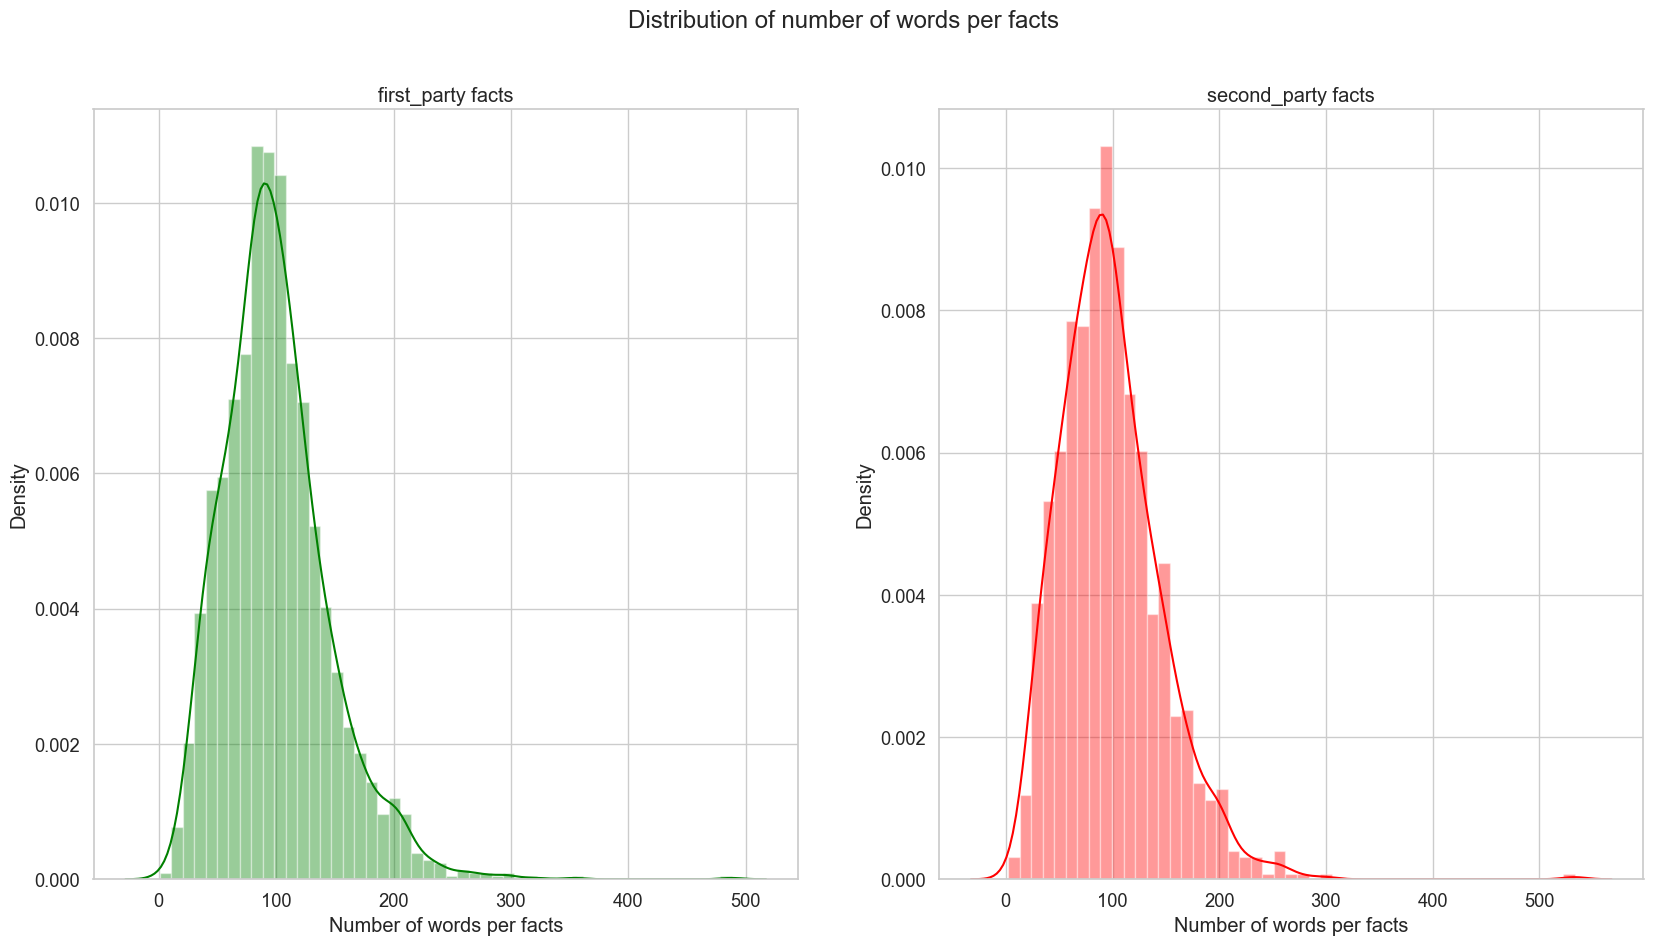

In [26]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = first_party_data.str.split().apply(lambda x : len(x) )
sns.distplot(word, ax=ax1,color='green')
ax1.set_title('first_party facts')
ax1.set_xlabel('Number of words per facts')
word = second_party_data.str.split().apply(lambda x :len(x) )
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('second_party facts')
ax2.set_xlabel('Number of words per facts')
fig.suptitle('Distribution of number of words per facts')
plt.show()

C:\Users\Anita Singh\AppData\Local\Temp\ipykernel_24740\2829644745.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
C:\Users\Anita Singh\AppData\Local\Temp\ipykernel_24740\2829644745.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word

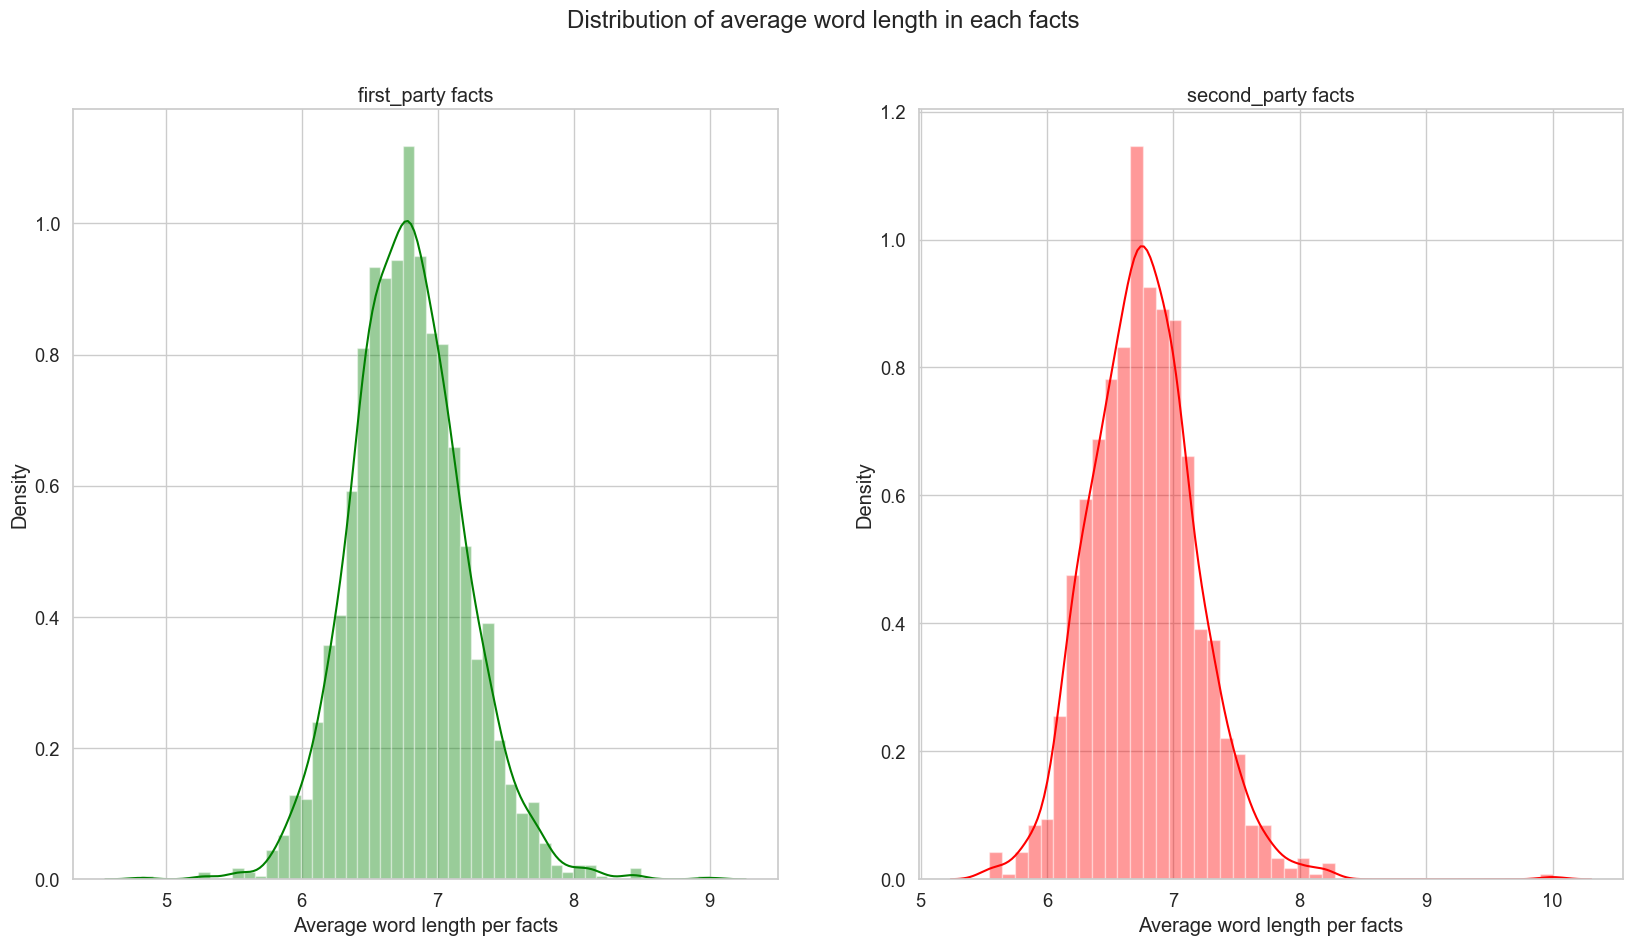

In [27]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = first_party_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
ax1.set_title('first_party facts')
ax1.set_xlabel('Average word length per facts')
word = second_party_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('second_party facts')
ax2.set_xlabel('Average word length per facts')
fig.suptitle('Distribution of average word length in each facts')
plt.show()

In [28]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.facts)
corpus[:5]

['jane', 'roe', 'fictional', 'name', 'used']

In [29]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

corpus  countv
0     court   11168
1  district    4072
2     state    3694
3    appeal    3549
4   federal    2390
5   circuit    2214
6         u    2129
7       act    2097
8      held    1590
9   supreme    1568

In [30]:
most_common = most_common.sort_values('countv')

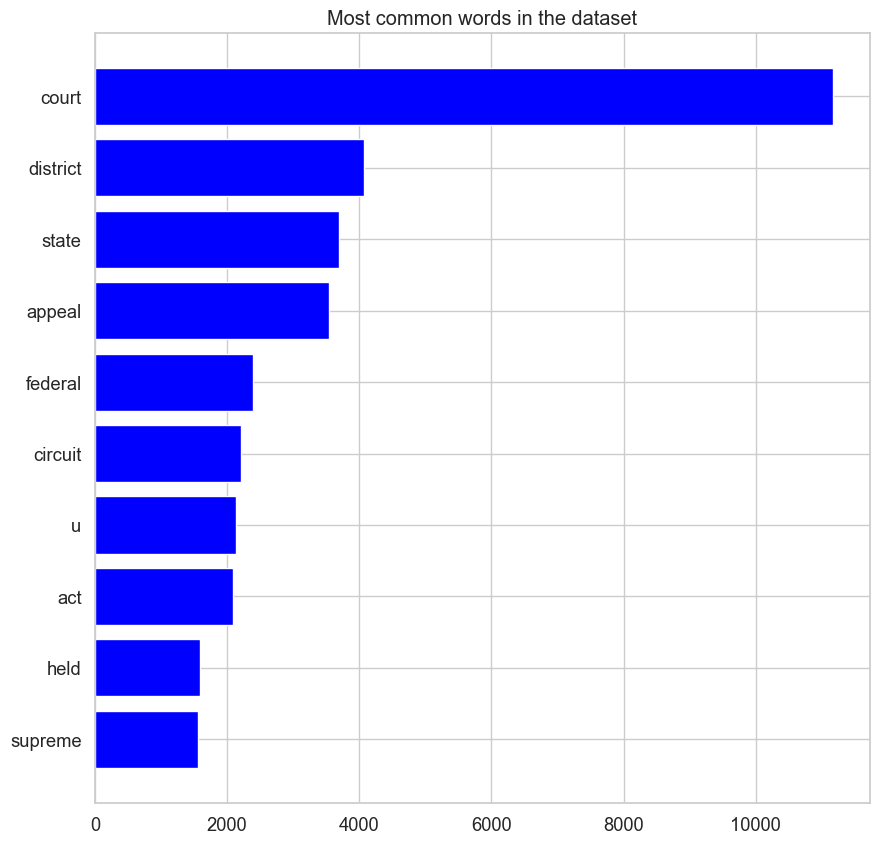

In [31]:
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.show()

In [32]:
def get_ngrams(facts, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(facts)
    bag_of_words = vec.transform(facts) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency 
    return words_freq[:n]

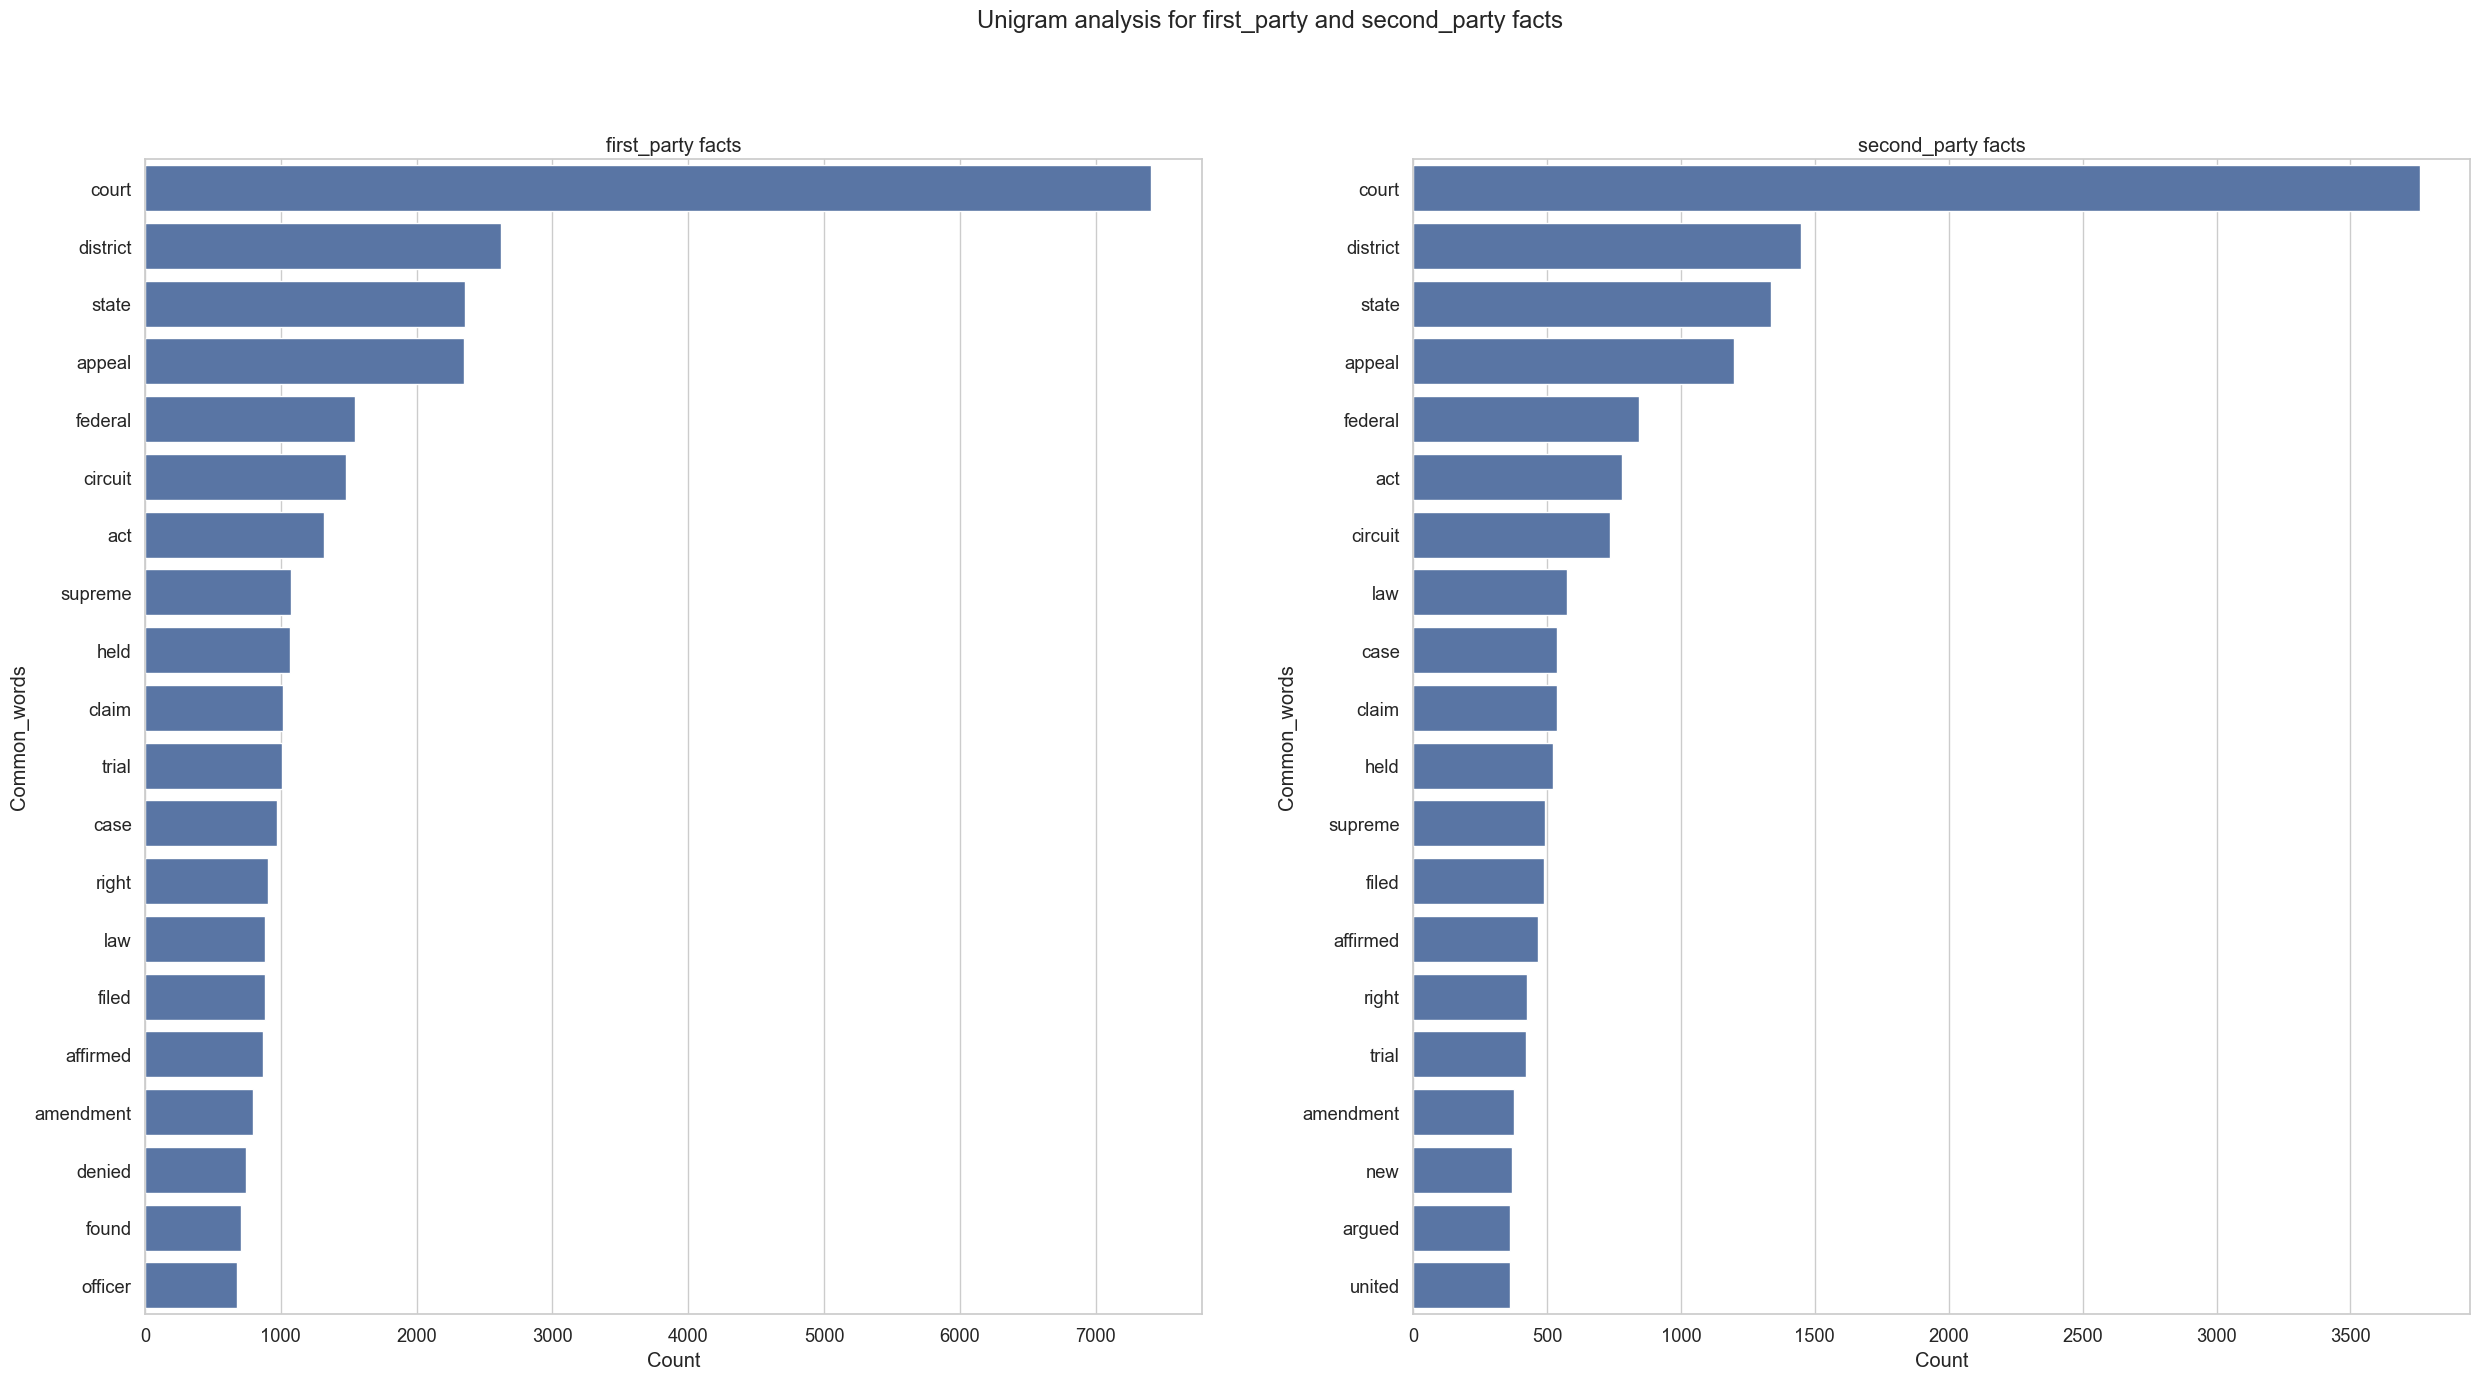

In [33]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
uni_first_party = get_ngrams(first_party_data,20,1)
uni_first_party = dict(uni_first_party)
temp = pd.DataFrame(list(uni_first_party.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('first_party facts')
uni_second_party = get_ngrams(second_party_data,20,1)
uni_second_party = dict(uni_second_party)
temp = pd.DataFrame(list(uni_second_party.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('second_party facts')
fig.suptitle('Unigram analysis for first_party and second_party facts')
plt.show()

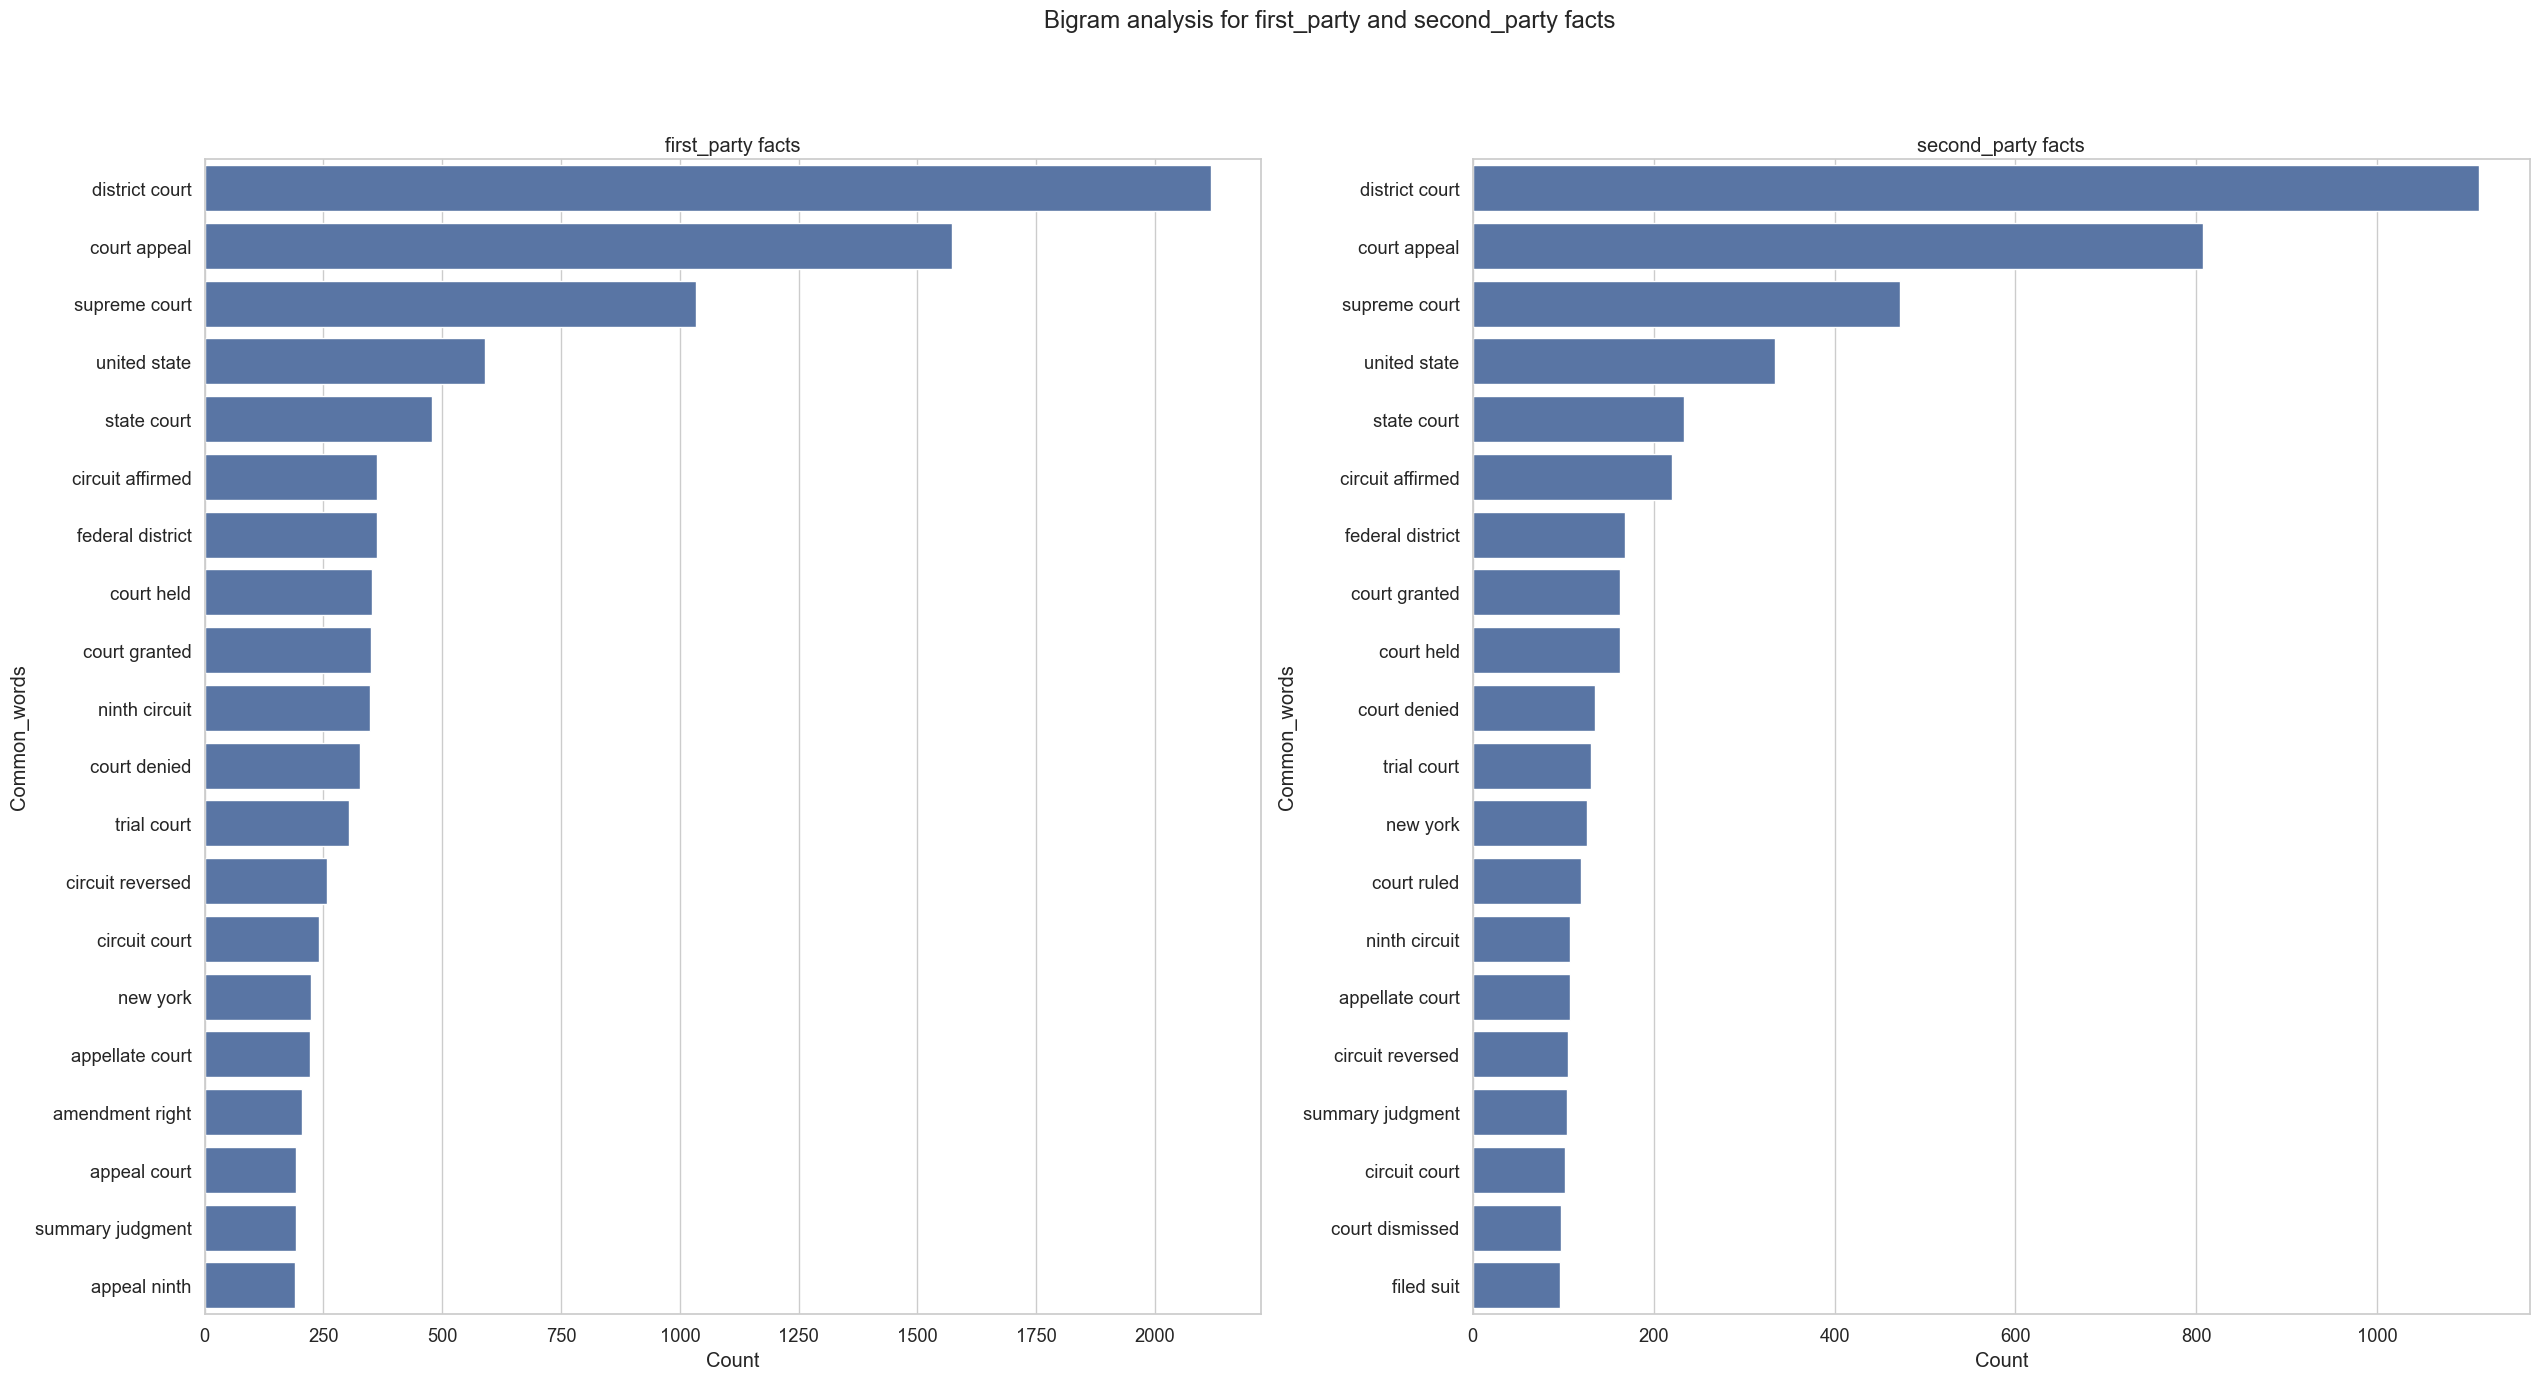

In [34]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
bi_first_party = get_ngrams(first_party_data,20,2)
bi_first_party = dict(bi_first_party)
temp = pd.DataFrame(list(bi_first_party.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('first_party facts')
bi_second_party = get_ngrams(second_party_data,20,2)
bi_second_party = dict(bi_second_party)
temp = pd.DataFrame(list(bi_second_party.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('second_party facts')
fig.suptitle('Bigram analysis for first_party and second_party facts')
plt.show()

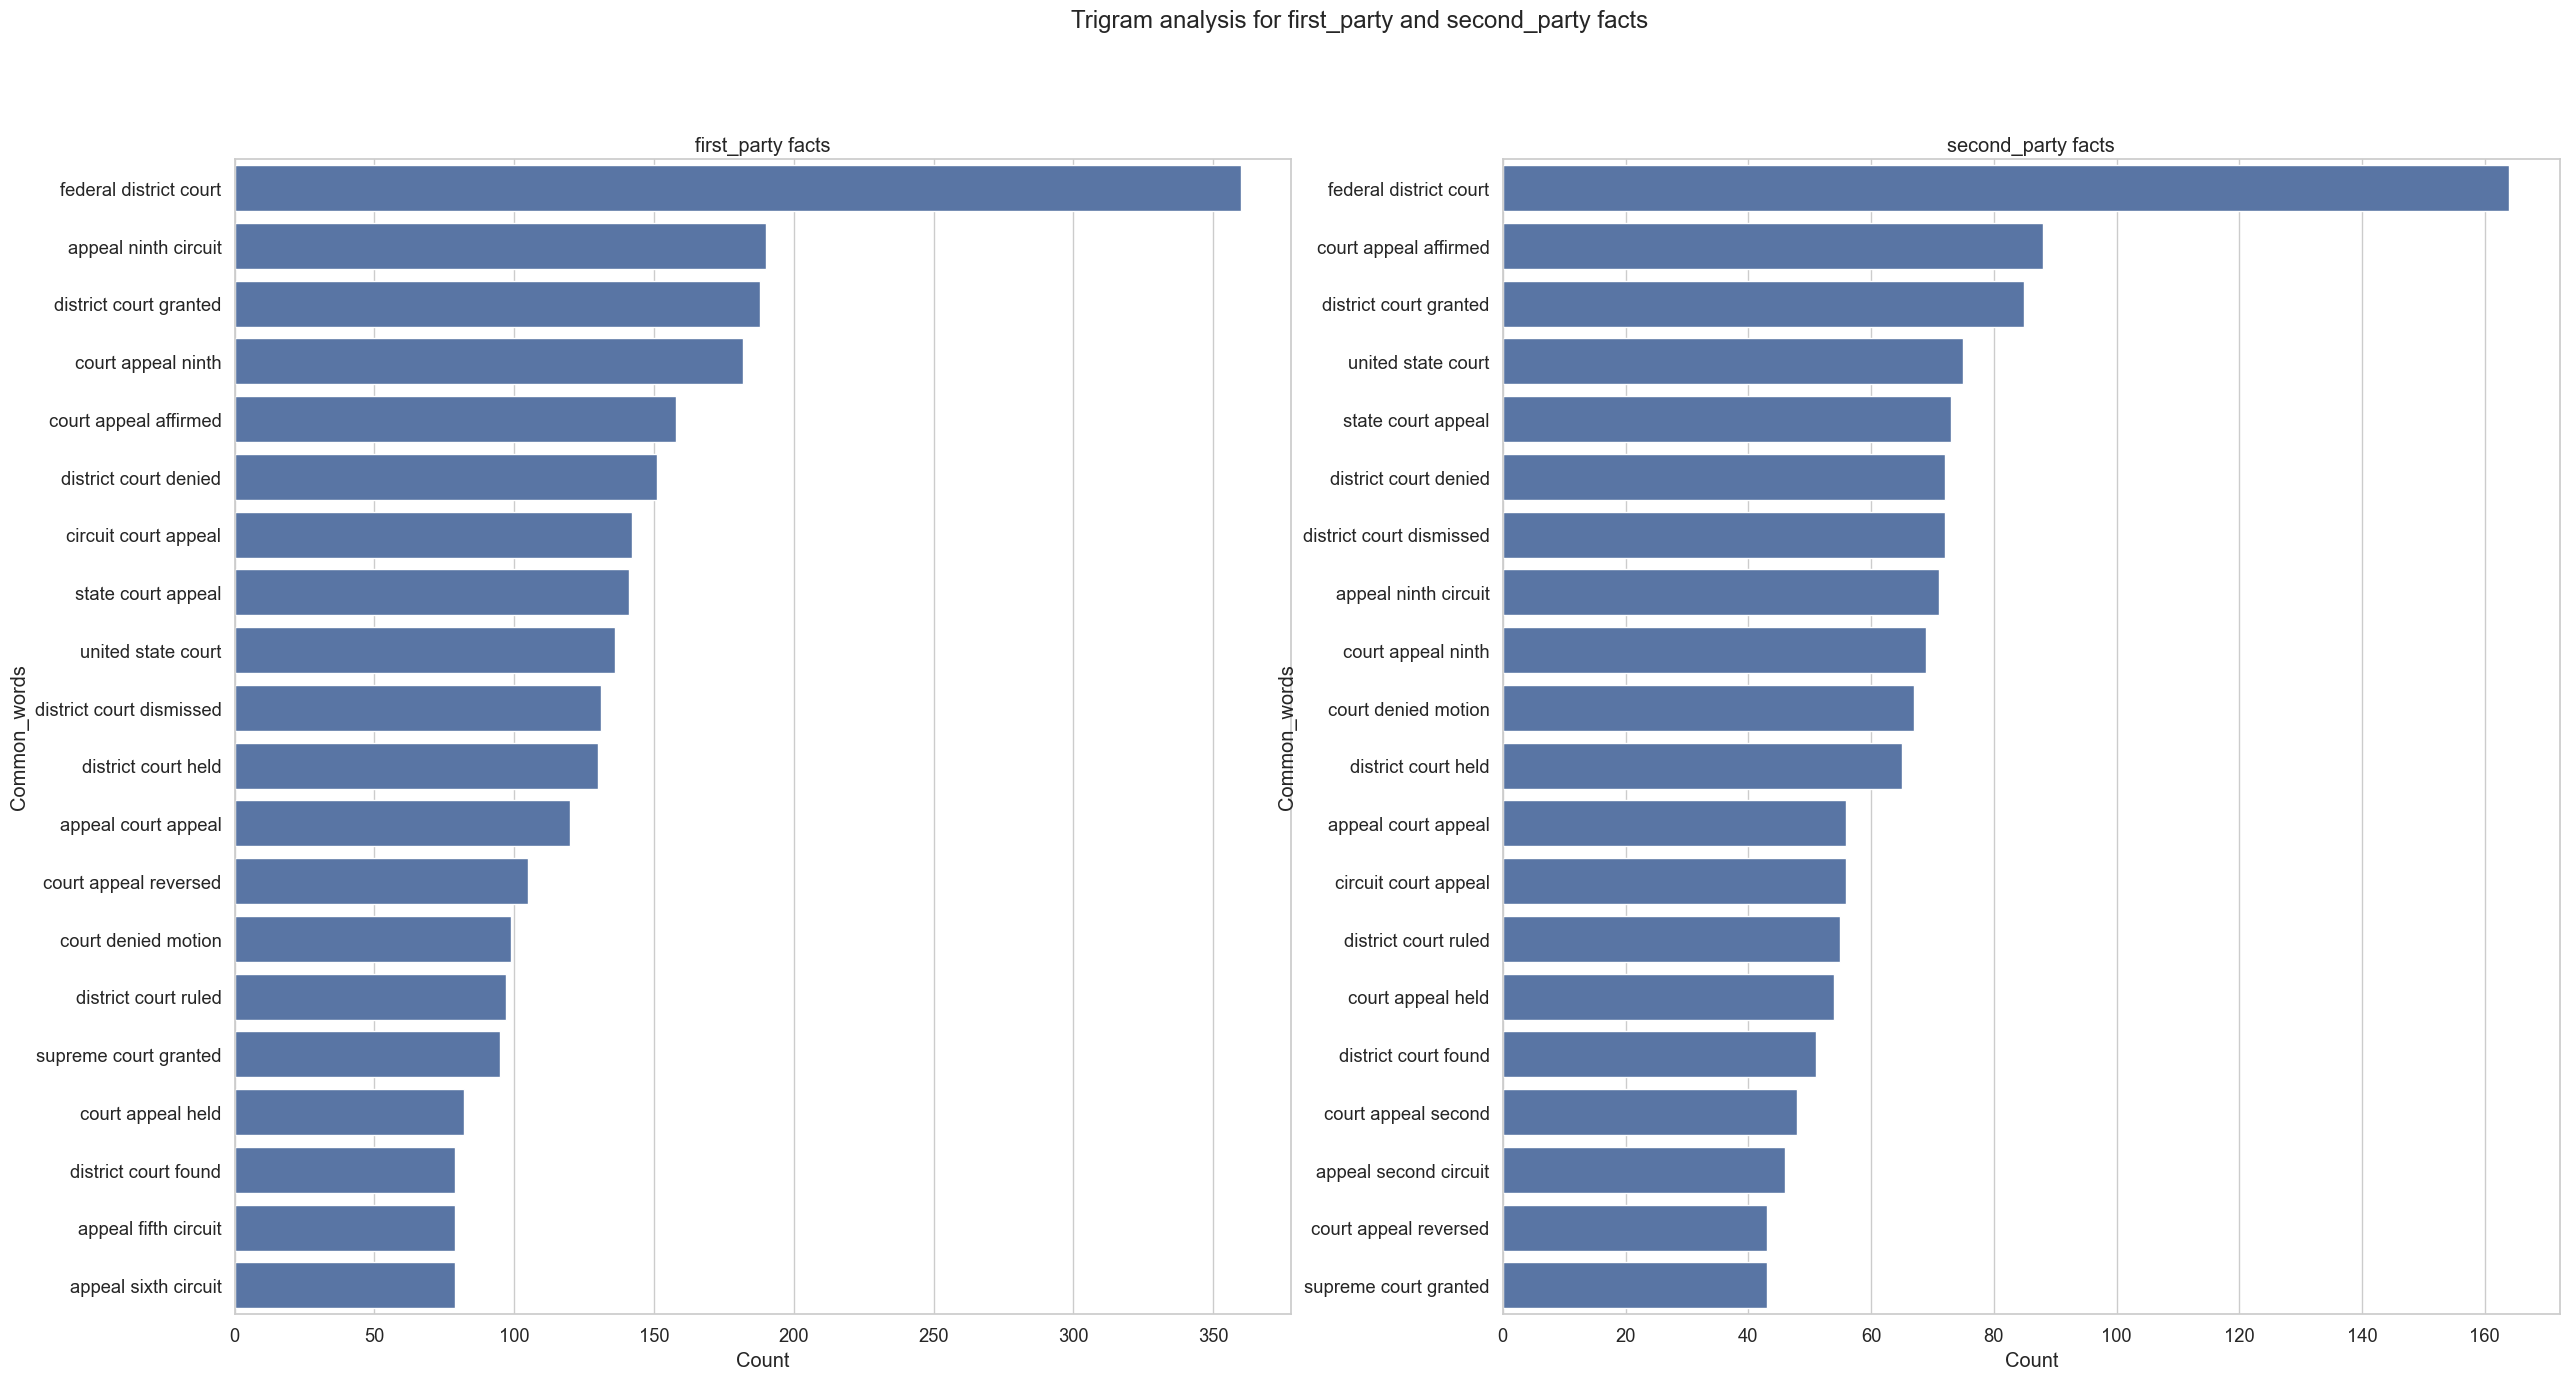

In [35]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
tri_first_party = get_ngrams(first_party_data,20,3)
tri_first_party = dict(tri_first_party)
temp = pd.DataFrame(list(tri_first_party.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('first_party facts')
tri_second_party = get_ngrams(second_party_data,20,3)
tri_second_party = dict(tri_second_party)
temp = pd.DataFrame(list(tri_second_party.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('second_party facts')
fig.suptitle('Trigram analysis for first_party and second_party facts')
plt.show()